## 02 EDA  
(introduction here)

#### Skip Ahead:  
[Read and Concatenate](#Read-and-Concatenate)  
[Exploration](#Exploration)  
[Significant Words](#Significant-Words)  
[Epilogue](#Epilogue)

In [47]:
#imports
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
#week 3
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#week 4
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
#week 5
import requests
from bs4 import BeautifulSoup

### Read and Concatenate

In [48]:
xb = pd.read_csv('../sub_data/Xbox_10k.csv') #read in xbox data
xb.shape

(10005, 8)

In [49]:
ps = pd.read_csv('../sub_data/Playstation_10k.csv')
ps.shape

(10021, 8)

In [50]:
df = pd.concat([xb, ps], ignore_index=True) #make 1 dataframe with all the posts from r/xbox and r/playstatino

In [51]:
df.shape

(20026, 8)

In [52]:
df.head()

,subreddit,id,author,num_comments,selftext,title,upvote_ratio,url
0,xbox,jc40iu,ImmaPoodle,1,So watch dogs legion is coming out soon and wi...,Ubisoft vs Rockstar,1.0,https://www.reddit.com/r/xbox/comments/jc40iu/...
1,xbox,jc3ty3,jaaytf_,2,hey so my xbox one is turning on and instantly...,xbox one problems:),1.0,https://www.reddit.com/r/xbox/comments/jc3ty3/...
2,xbox,jc3tg4,Matty_Rts,0,"For context, I purchased game pass on Xbox One...",My Preorder download for Beyond Light Disappea...,1.0,https://www.reddit.com/r/xbox/comments/jc3tg4/...
3,xbox,jc39t3,Rorydo44,2,I had $50 worth of gift cards in my account an...,Missing gift cards,1.0,https://www.reddit.com/r/xbox/comments/jc39t3/...
4,xbox,jc37vv,NonsenseText,0,Hi everyone! \n\nI would like to learn more ab...,Advice for Xbox online security?,1.0,https://www.reddit.com/r/xbox/comments/jc37vv/...


In [53]:
df.tail()

,subreddit,id,author,num_comments,selftext,title,upvote_ratio,url
20021,playstation,hf6ijf,IamXnoskillzX,3,I pre ordered the game awhile ago and now it s...,Did Sony Pull Ghosts Of Tsushima From Amazon?,1.00,https://www.reddit.com/r/playstation/comments/...
20022,playstation,hf5tl0,[deleted],0,NaN,Need help from PlayStation fans!,1.00,https://www.reddit.com/r/playstation/comments/...
20023,playstation,hf5rp1,ngocan2121,5,im just a casual player so here is my list and...,"Looking for sad story game with nice gameplay,...",0.75,https://www.reddit.com/r/playstation/comments/...
20024,playstation,hf58u2,SwingDingeling,10,Or evwn 8K?,Will every PS5 game be in 4K?,0.50,https://www.reddit.com/r/playstation/comments/...
20025,playstation,hf50cd,[deleted],1,[deleted],[HELP] somebody is using my email for a PlaySt...,0.50,https://www.reddit.com/r/playstation/comments/...


In [54]:
df['subreddit'].value_counts() #looks right

playstation    10021
xbox           10005
Name: subreddit, dtype: int64

### Exploration

My first task is going to be distinguishing between which subreddit posts came from. However, in the future I also want to look deeper into which words are popular in the playstation subreddit to find what those gamers value and potentially assist Microsoft's marketing team in winning over more customers. With that target in mind, I'll make the playstation reddit my "1" or target, and the xbox subreddit my "0".

In [55]:
df['subreddit'] = df['subreddit'].map({'xbox':0, 'playstation':1})

That worked! Time to check for null values and duplicates.

In [56]:
df.isnull().sum()

subreddit         0
id                0
author            0
num_comments      0
selftext        971
title             0
upvote_ratio      0
url               0
dtype: int64

Okay, 971 entries where self_text is empty, but everything else looks good!

In [57]:
df['selftext'].value_counts().sort_values(ascending=False).head(10)

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              325
Title                                                                                        

So there is a high number of [deleted] selftext items, and then some that just say 'Title', and then some that use punctuation (either '.' or '?'). I wonder if I have any duplicate posts.

In [58]:
df['title'].value_counts()

I need help                                                                                    20
Help                                                                                           14
Latest update                                                                                  12
Quick question                                                                                 12
Backwards compatibility                                                                        10
                                                                                               ..
What do you think will be Playstation's approach to the game edition consoles they release?     1
Bungie and Xbox                                                                                 1
Xbox Pro controller series 2 help                                                               1
Cant login to psn                                                                               1
Won't download even 

There do appear to be some duplicate titles, but they're a little generic so I can't be sure if it's a true repost or just a commonly invoked title for similar issues. I'm going to drop all but the last row for any posts that share the same author, title and selftext.

In [59]:
#https://www.codegrepper.com/code-examples/python/pandas+drop+duplicates+multiple+columns
#link provided by James Salisbury

In [60]:
df = df.drop_duplicates(subset=['author', 'title', 'selftext'], keep='last')

In [61]:
df.shape

(19942, 8)

There we go - we dropped about 70 rows of duplicate posts! Now I want to revisit my selftext value counts.

In [62]:
df['selftext'].value_counts().sort_values(ascending=False).head(10)

[deleted]      319
Title           35
.               32
?               14
Help            10
Please help      8
Title.           7
title            7
Thanks           5
Thank you        4
Name: selftext, dtype: int64

In [63]:
#https://stackoverflow.com/questions/14281871/given-a-pandas-series-that-represents-frequencies-of-a-value-how-can-i-turn-tho

In [64]:
#df[(df['selftext'] == '[deleted]') | (df['selftext'] == 'Title')]
df[df['selftext'] == '[deleted]']['subreddit'].value_counts(normalize=True)

0    0.611285
1    0.388715
Name: subreddit, dtype: float64

About 61% of [deleted] posts are from the Xbox subreddit.

In [65]:
df[(df['selftext'] == '.') | (df['selftext'] == '?')]['subreddit'].value_counts(normalize=True)

1    0.891304
0    0.108696
Name: subreddit, dtype: float64

Using only punctuation in selfpost text seems much more popular in the playstation subreddit (89%)

In [66]:
df[(df['selftext'] == 'Help') | (df['selftext'] == 'Please help') | (df['selftext'] == 'Thanks')]['subreddit'].value_counts(normalize=True)

1    0.608696
0    0.391304
Name: subreddit, dtype: float64

Playstation subredditors have a slight edge on "polite" selftext (that consists of 'help' or 'thanks) - 61%

In [67]:
df[(df['selftext'] == 'Title') | (df['selftext'] == 'Title.') | (df['selftext'] == 'title') | (df['selftext'] == 'Title says it all')]['subreddit'].value_counts(normalize=True)

1    0.735849
0    0.264151
Name: subreddit, dtype: float64

It looks like roughly 74% of posts that included some generic form of the word 'Title' were all from the Playstation subreddit.

Some of these posts with [deleted] selftext still have a) valid titles and b) comments, so I could entertain arguments in support of keeping them. The titles still may represent patterns of communication popular among those who post in their respective subreddits. On the other hand, because there is not a particularly strong correlation to either Xbox or Playstation among posts that include the [deleted] selftext, I'm not sure it's actually going to help my classification model. The same could be said for titles that include some form of 'help' or 'thanks'. I want to check if the actual titles have similar patterns.

In [68]:
df['title'].value_counts().head(10)

I need help                20
Quick question             12
Help                       11
Backwards compatibility    10
I need some help            8
Xbox live                   7
Help please                 7
Please help                 6
Xbox live gold              5
Game pass question          5
Name: title, dtype: int64

There appear to be much fewer repeats of titles as compared to selftext - the most used title only appears 20 times out of 20k rows! I wonder if the 'help' themed titles break down similarly in proportion between the subreddits to how the 'help' selftext was distributed?

In [69]:
df[(df['title'] == 'I need help') | (df['title'] == 'Help') | (df['title'] == 'I need some help') | (df['title'] == 'Help please') | (df['title'] == 'Please help')]['subreddit'].value_counts(normalize=True)

1    0.653846
0    0.346154
Name: subreddit, dtype: float64

Interesting. About 65% of the 'help' themed titles are from the Playstation subreddit, which is not far off the split of the 'help' themed selftexts (61%). That word might actually prove to be a *helpful* feature in my classification model.

In conclusion RE what to do with these duplicate titles and selftexts, I'm going to eliminate the posts the have [deleted] as their selftext. I don't want that word to skew my model - I could remove the word but I'm not sure it's fair to imagine these deleted posts to be the same as posts for which no self-text was entered, of which there are a substantial amount (971) as we saw earlier. Without knowing the circumstances of each post deletion, I cannot definitively say whether these deleted posts are a helpful representation of their subreddit because I don't know the circumstances of deletion or how long they were even up prior to deletion.  

With regards to the other recurring selftext and title keywords, I am going to keep them. In most cases there is an above 70% correlation to one subreddit or the other for the given words, and in the case of 'help' themed titles/selftext, while the diparity is not the different, it does seem to be consistently reflected both in title and selftext distribution so it may yet prove to be significant.

In [70]:
df = df.copy()

In [71]:
df = df[df['selftext'].map(lambda x: x != '[deleted]')]

In [72]:
df['selftext'].value_counts().head(5)

Title          35
.              32
?              14
Help           10
Please help     8
Name: selftext, dtype: int64

Okay, that did it!  

Next, I want to create a new column that concatenates the 'selftext' and 'title' column text together in order to be able to include all of their combined text in my model. Before I can do that, I need to take care of the null values in my selftext column.

In [73]:
df.isnull().sum()

subreddit         0
id                0
author            0
num_comments      0
selftext        963
title             0
upvote_ratio      0
url               0
dtype: int64

In [74]:
df.fillna('', inplace=True) #replace nan selftext values with empty string

In [75]:
df['all_text'] = df['title'] + ' ' + df['selftext'] #concatenate title and selftext into one string

In [76]:
df.head() #preview

,subreddit,id,author,num_comments,selftext,title,upvote_ratio,url,all_text
1,0,jc3ty3,jaaytf_,2,hey so my xbox one is turning on and instantly...,xbox one problems:),1.0,https://www.reddit.com/r/xbox/comments/jc3ty3/...,xbox one problems:) hey so my xbox one is turn...
2,0,jc3tg4,Matty_Rts,0,"For context, I purchased game pass on Xbox One...",My Preorder download for Beyond Light Disappea...,1.0,https://www.reddit.com/r/xbox/comments/jc3tg4/...,My Preorder download for Beyond Light Disappea...
3,0,jc39t3,Rorydo44,2,I had $50 worth of gift cards in my account an...,Missing gift cards,1.0,https://www.reddit.com/r/xbox/comments/jc39t3/...,Missing gift cards I had $50 worth of gift car...
4,0,jc37vv,NonsenseText,0,Hi everyone! \n\nI would like to learn more ab...,Advice for Xbox online security?,1.0,https://www.reddit.com/r/xbox/comments/jc37vv/...,Advice for Xbox online security? Hi everyone! ...
5,0,jc36eg,Mondo-Butter-21,4,"Srsly tho, how tf did Doom Eternal get onto th...",Anyone else think it’s fucking hilarious that ...,1.0,https://www.reddit.com/r/xbox/comments/jc36eg/...,Anyone else think it’s fucking hilarious that ...


Easy enough! Now I can build a classification model based on the 'all_text' column with the maximum amount of text to differentiate between post origin subreddit.

### Significant Words  

Before I launch into modeling, I want to take a look at my data, by subreddit and as a whole, to see which words and/or phrases appear most frequently. I'd also be interested to see if there is any clear sentiment distinctions among or between the two subreddits. I'd also be curious to know how much overlap (if any) there is between usernames of posters - do some redditors contribute to both Xbox and Playstation? Finally, I'm curious if there is a distinction between length of post between the subreddits - is one community more longwinded than the other?

#### Tokenize/Lemmatize/Group  
To do this effectively, I'm going to make 2 more dataframes from my clean dataframe, each containing only 1 subreddit's information. That way I can evaluate not only the words that run through all 20k rows but also the words unique to each subreddit. I'm also going to write a function to perform the tokenizing, lemmatizing, and subsequent bar chart of most frequent words all in one execution, then I can just call it in three times to get the information I want.

In [82]:
#https://stackoverflow.com/questions/35582531/pandas-subplot-title-size-in-ipython-notebook

In [77]:
x_clean = df[df['subreddit']==0] #new clean xbox-only dataframe
ps_clean = df[df['subreddit']==1] #new clean playstation only dataframe

In [126]:
#referred to lesson 5.03 and 5.04
#https://stackoverflow.com/questions/40902430/lemmatization-inside-array-using-nltk-python
from nltk.corpus import stopwords
swords = set(stopwords.words('english')) #set nltk stopword list equal to a variable
swords.update(['ps5', 'xbox', 'ps4', 'wa', 'ps3', 'playstation',
              'would', 'anyone', 'like', 'play', 'get', 'ha', 'game',
              'sony', 'series', 'got', 'one', 'know', 'want', 'buy', 'ps',
              '360', 'microsoft', 'new', 'time', 'need', 'pas',
              'still', 'work', 'psn']) #add words to stopwords list
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+') #create tokenizer to remove punctuation
cvec = CountVectorizer(stop_words=swords, #remove stop words
                       ngram_range=(1,2), #single and paired words
                       max_df=.4, #ngram has to appear in 40% or less of posts
                       min_df=4, #ngram has to appear at least 4 times
                       max_features=20_000) #maximum 20k features

def tokemmetizer(dataframe): #create function to tokenize and lemmatize
    X = dataframe['all_text']
    X_tokens = [tokenizer.tokenize(word) for word in X] #tokenize all words
    X_lem = []
    for item in X_tokens:
        X_post = []
        for word in item:
            X_post.append(lemmatizer.lemmatize(word)) #remove stop words
        X_lem.append(' '.join(X_post)) #rejoin lemmatized word list into strings
    X_c = cvec.fit_transform(X_lem) #pass posts through count vectorizer
    X_c_df = pd.DataFrame(X_c.todense(), columns=cvec.get_feature_names()) #make df showing word frequency
    return X_c_df #return dataframe of values 

In [127]:
all_words = tokemmetizer(df)
x_words = tokemmetizer(x_clean)
ps_words = tokemmetizer(ps_clean)

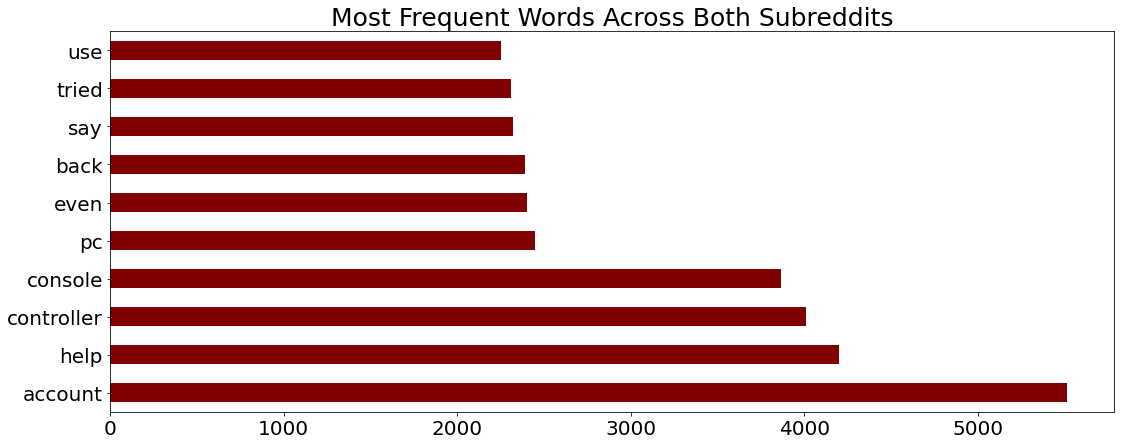

In [128]:
plt.figure(figsize=(18,7))

all_words.sum().sort_values(ascending=False).head(10).plot.barh(
    fontsize = '20',
    color='maroon'); #make bar chart of most frequent 10 words    
plt.title('Most Frequent Words Across Both Subreddits', size=25);
#plt.savefig('../images/mfw_both2.png', dpi=200, bbox_inches='tight');

Clearly Xbox redditors LOVE using the word xbox. It's far and away the most common word in the combined dataset. After that we have words we might expect like "play" and "get".

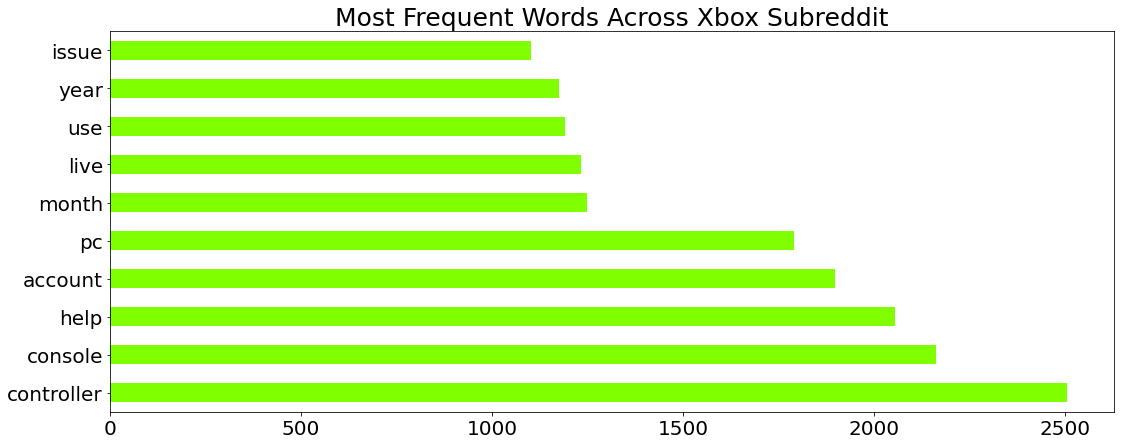

In [131]:
#plt.title('Most Frequent Words Across Xbox Subreddit', color='gray')
plt.figure(figsize=(18,7))
x_words.sum().sort_values(ascending=False).head(10).plot.barh(
    fontsize = '20',
    color='chartreuse'); #make bar chart of most frequent 10 words  
plt.title('Most Frequent Words Across Xbox Subreddit', size=25);
#plt.savefig('../images/mfw_xbox2.png', dpi=200, bbox_inches='tight');

Xbox users tend to reference "controller" and "console" more than playstation redditors, suggesting perhaps they troubleshoot hardware issues more frequently than their PS counterparts.

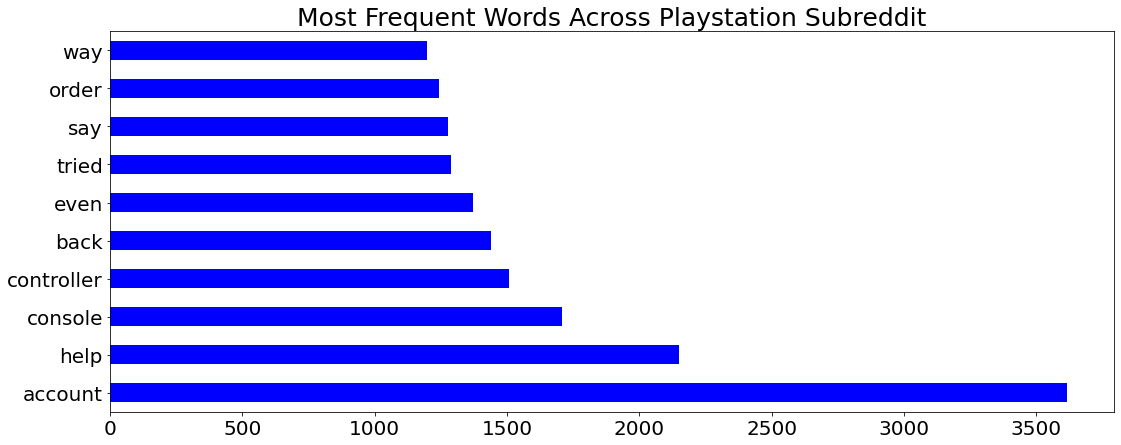

In [132]:
#plt.title('Most Frequent Words Across Playstation Subreddit', color='navy')
plt.figure(figsize=(18,7))
ps_words.sum().sort_values(ascending=False).head(10).plot.barh(
    fontsize = '20',
    color='blue'); #make bar chart of most frequent 10 words  
plt.title('Most Frequent Words Across Playstation Subreddit', size=25);
#plt.savefig('../images/mfw_ps2.png', dpi=200, bbox_inches='tight');

Playstation redditors reference the word "account" quite a bit, indicating more discussions about software glitches or login issues. This could be valuable for Microsoft's marketing team to be aware of - perhaps they should advertise highlighting Xbox's simple/intuitive/"glitch-free" account creation / sign-in process.

#### Sentiment

In [45]:
#referred to lesson 5.03
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

def avg_sentiment(dataframe): #finds mean of compound polarity score of all posts, rounds to 2 digits
    return round(np.mean([sentiment.polarity_scores(post)['compound'] for post in dataframe]),2)

In [48]:
print(f"The overall sentiment for both subreddits is: {avg_sentiment(df['all_text'])}")
print(f"The sentiment for the Xbox subreddit is: {avg_sentiment(x_clean['all_text'])}")
print(f"The sentiment for the Playstation subreddit is: {avg_sentiment(ps_clean['all_text'])}")

The overall sentiment for both subreddits is: 0.27
The sentiment for the Xbox subreddit is: 0.29
The sentiment for the Playstation subreddit is: 0.26


In this case it appears each subreddit has a slight positive tilt (Xbox marginally moreseo), leading to an overall positive sentiment for the combined DataFrame.

#### Usernames

In [113]:
#df['author'].value_counts()
#df['author'].value_counts()>1
auth_list = df.groupby('author')['author'].count().sort_values(ascending=False)

In [116]:
auth_list = dict(auth_list)

In [119]:
reposters = []
for key, value in auth_list.items():
    if value > 1 and key != '[deleted]': #filter for posters with more than 1 post and name not deleted
        reposters.append(key)

In [121]:
len(reposters) #all authors who have more than 1 post to their name

2077

Okay out of my ~20k posts, a little over 2_000 (or 10%) of my post authors posted more than once. I'm curious if there is an overlap i.e. any authors that cross-posted between both subreddits.

In [150]:
#https://www.kite.com/python/answers/how-to-find-common-elements-between-two-lists-in-python

In [152]:
def get_authors(dataframe): #function to get unique authors from each subreddit dataframe
    auths_only = []
    auths = dict(dataframe.groupby('author')['author'].count()) #make dictionary of unique authors and # of posts
    for key, value in auths.items(): #split dictionary
        auths_only.append(key) #get author names only
    return set(auths_only) #return list of authors

In [153]:
x_auths = get_authors(x_clean)
len(x_auths) #list of unique xbox authors

8135

In [154]:
ps_auths = get_authors(ps_clean)
len(ps_clean) #list of unique playstation authors

9858

Average post per author: 1.2275115726260477


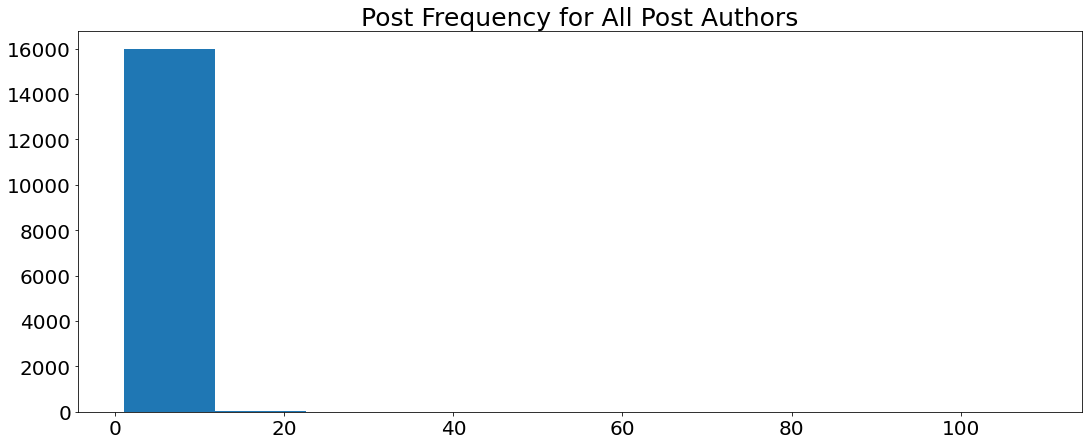

In [217]:
t_posts_list = []
for key, value in auth_list.items():
    t_posts_list.append(value)
print(f'Average post per author: {np.mean(t_posts_list)}') #average posts for all authors in entire data set
plt.figure(figsize=(18,7))
plt.title('Post Frequency for All Post Authors', size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.hist(t_posts_list);

As seen in the histogram above, the average unique author across both subreddits is credited with about 1 post each on average (~1.23). This suggests that there is a small core of vocal redditors who post regularly, but the majority of people are posting very infrequently.

In [157]:
shared_auths = x_auths.intersection(ps_auths)
len(shared_auths) #183 authors in common!

183

In [165]:
shareposts = 0
for author in shared_auths:
    shareposts += auth_list[author] #index into my dictionary of all authors with more than 1 post from above
shareposts/len(shared_auths)  #average posts per poster who posted on both subreddits

4.038251366120218

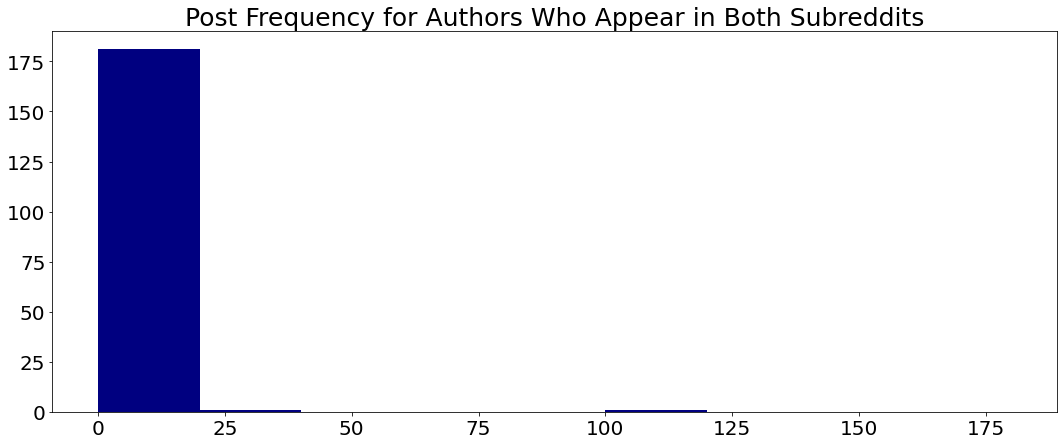

In [195]:
postlist = []
for author in shared_auths:
    postlist.append(auth_list[author])
plt.figure(figsize=(18,7))
plt.title('Post Frequency for Authors Who Appear in Both Subreddits', size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.hist(postlist, bins=list(range(0,200,20)), color='navy');

As seen above, of our 183 authors that appear in both the Xbox and Playstation subreddits, on average they each have about 4 posts to their names. Again, we see a slight right skew where a fraction of posters are substantially more active than the rest.

#### Length of Post

In [130]:
def avg_length(dataframe): #create function to find average length of post
    return round(np.mean([len(p.split()) for p in dataframe['all_text']]),2)

In [146]:
print(f'Average Length of all text in both subreddits: {avg_length(df)}')
print(f'Average Length of all text in Xbox subreddit: {avg_length(x_clean)}')
print(f'Average Length of all text in Playstation subreddit: {avg_length(ps_clean)}')

Average Length of all text in both subreddits: 71.74
Average Length of all text in Xbox subreddit: 68.11
Average Length of all text in Playstation subreddit: 75.34


It looks like posts aren't too different in terms of length but on average Playstation posts are about 7 words longer.

### Epilogue  

Alright, this data is cleaned up and ready for modeling. I'm going to save it as its own .csv file and then I'll load it into a new classification notebook to build and test some models.

In [34]:
#df.to_csv('../sub_data/clean_subs.csv', index=False)